In [164]:
#!pip install torch_geometric

In [1]:
from algorithms.dif import DIF

import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

 - Ejecutar individualmente todas las columnas y sacar su score unico
 - En Excel pintar en paralelo la curva datos originales y la curva score
 - Ejecutar modelo Constante vs Creciente
 - Ejecutar modelo todos
 - Confirmar significado score, a partir de cuando es anomalia
 

# Import data

In [2]:
df_ini = pd.read_csv('./data/tabular/datos_vacio.csv', sep = ';',index_col=0)
df = df_ini[df_ini['day_time_index']<=600]
df_orig = df.copy()
df = df[['day_time_index', 'Vacio_01', 'Vacio_03', 'Vacio_05',
       'Vacio_07', 'Vacio_11', 'Vacio_13', 'Vacio_19', 'Vacio_23', 'Vacio_25',
       'Vacio_26', 'Vacio_27', 'Vacio_28', 'Vacio_32', 'Vacio_33', 'Vacio_34',
       'Vacio_35', 'Vacio_36', 'Vacio_37', 'Vacio_38', 'Vacio_39', 'Vacio_41',
       'Vacio_42', 'Vacio_43', 'Vacio_45', 'Vacio_47', 'Vacio_48', 'Vacio_49',
       'Vacio_50', 'Vacio_51', 'Vacio_52', 'Vacio_54', 'Vacio_56', 'Vacio_57',
       'Vacio_58', 'Vacio_59', 'Vacio_60', 'Vacio_61', 'Vacio_62', 'Vacio_63',
       'Vacio_64']]

## Preparacion datos

In [3]:
# sensores contantes
df_cons = df[['day_time_index',
                   'Vacio_01','Vacio_05','Vacio_07','Vacio_11','Vacio_13',
                   'Vacio_19','Vacio_23','Vacio_25','Vacio_28','Vacio_32','Vacio_33',
                   'Vacio_34','Vacio_35','Vacio_36','Vacio_37','Vacio_38','Vacio_39','Vacio_42','Vacio_43',
                   'Vacio_45','Vacio_49','Vacio_50','Vacio_51','Vacio_52','Vacio_54',
                   'Vacio_56','Vacio_57','Vacio_58','Vacio_59','Vacio_60','Vacio_62','Vacio_63']]

# sensores crecientes
df_crec = df[['day_time_index','Vacio_03','Vacio_26' ,'Vacio_27','Vacio_41','Vacio_47',
                    'Vacio_48','Vacio_61','Vacio_64']] #

# En fase de calentamiento 
df_calent = df[((df.index == '2024_0079') & (df['day_time_index'] <= 203)) | 
                      ((df.index == '2024_0093') & (df['day_time_index'] <= 194)) | 
                      ((df.index == '2024_0105') & (df['day_time_index'] <= 186))]

# En fase de estabilizacion
df_estab = df[((df.index == '2024_0079') & (df['day_time_index'] > 203)) | 
                      ((df.index == '2024_0093') & (df['day_time_index'] > 194)) | 
                      ((df.index == '2024_0105') & (df['day_time_index'] > 186))]

# Sensores constantes en fase de calentamiento
df_cons_calent = df_calent[['day_time_index',
                   'Vacio_01','Vacio_05','Vacio_07','Vacio_11','Vacio_13',
                   'Vacio_19','Vacio_23','Vacio_25','Vacio_28','Vacio_32','Vacio_33',
                   'Vacio_34','Vacio_35','Vacio_36','Vacio_37','Vacio_38','Vacio_39','Vacio_42','Vacio_43',
                   'Vacio_45','Vacio_49','Vacio_50','Vacio_51','Vacio_52','Vacio_54',
                   'Vacio_56','Vacio_57','Vacio_58','Vacio_59','Vacio_60','Vacio_62','Vacio_63']]

# Sensores constantes en fase de estabilizacion
df_cons_estab = df_estab[['day_time_index',
                   'Vacio_01','Vacio_05','Vacio_07','Vacio_11','Vacio_13',
                   'Vacio_19','Vacio_23','Vacio_25','Vacio_28','Vacio_32','Vacio_33',
                   'Vacio_34','Vacio_35','Vacio_36','Vacio_37','Vacio_38','Vacio_39','Vacio_42','Vacio_43',
                   'Vacio_45','Vacio_49','Vacio_50','Vacio_51','Vacio_52','Vacio_54',
                   'Vacio_56','Vacio_57','Vacio_58','Vacio_59','Vacio_60','Vacio_62','Vacio_63']]

# Sensores crecientes en fase de calentamiento
df_crec_calent = df_calent[['day_time_index','Vacio_03','Vacio_26','Vacio_27','Vacio_41','Vacio_47',
                    'Vacio_48','Vacio_61','Vacio_64']]

# Sensores crecientes en fase de estabilizacion
df_crec_estab = df_estab[['day_time_index','Vacio_03','Vacio_26','Vacio_27','Vacio_41','Vacio_47',
                    'Vacio_48','Vacio_61','Vacio_64']]

print("df", df.shape)
print("df_cons", df_cons.shape)
print("df_crec", df_crec.shape)

print("df_calent", df_calent.shape)
print("df_estab", df_estab.shape)

print("df_cons_calent", df_cons_calent.shape)
print("df_cons_estab", df_cons_estab.shape)
print("df_crec_calent", df_crec_calent.shape)
print("df_crec_estab", df_crec_estab.shape)


df (1800, 41)
df_cons (1800, 33)
df_crec (1800, 9)
df_calent (583, 41)
df_estab (1217, 41)
df_cons_calent (583, 33)
df_cons_estab (1217, 33)
df_crec_calent (583, 9)
df_crec_estab (1217, 9)


## Funcion ejecucion

In [36]:
def train_test(df):
    
    # Dataframes train y test Escogemos 2 de los 3 ciclos como entrenamiento y el tercero para validacion
    df_train = df[df.index.isin(['2024_0105','2024_0079'])] # 
    df_test = df[df.index.isin(['2024_0093'])]
    
    # Array train y test para el algoritmo DIF
    X_train = df_train.values.astype(float)
    X_test = df_test.values.astype(float)

    return df_train, df_test, X_train, X_test

## Separacion por sensor

In [5]:
def separacion_sensor(df, i):
    # Funcion para extraer solo una columna sensor por cada vuelta del bucle for
    columnas = ['day_time_index']
    columnas_sens = columnas + [df.columns[i]]
    print(columnas_sens)
    df_sens = df[columnas_sens]
    
    return df_sens

## Funcion llamada DIF

In [6]:
def score_anomalia(X_train, X_test, df_test, scoreName, model_configs, printPlot = False):
    
    model_configs = model_configs
    model = DIF(**model_configs)
    model.fit(X_train)
    score = model.decision_function(X_test)
     
    df_test[scoreName] = score
    
    print(max(df_test[scoreName]))
    if printPlot:
        plt.hist(df_test[scoreName])

    return df_test

## Ejecucion

network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 5}
0.4412774746270382


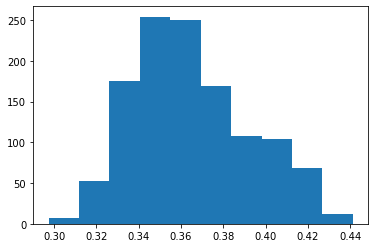

In [11]:
# Probamos con con los sensores catalogados como crecientes
# Con esos parámetros de entrenamiento la mayoria de instantes se concentran entre 0.3 y 0.4,
# pero también hay una serie de ocurrencias por encima de 0.4. Curiosamente son los últimos del proceso, ¿anomalías?
t_in = df_crec
df_train, df_test, X_train, X_test = train_test(t_in)
model_configs = {'n_ensemble':5, 'n_estimators':16, 'device':'cpu'}
df_test_score = score_anomalia(X_train, X_test, df_test, 'score', model_configs)

In [145]:
df_test_score[df_test_score['score']>0.40]

,day_time_index,Vacio_03,Vacio_26,Vacio_27,Vacio_41,Vacio_47,Vacio_48,Vacio_61,Vacio_64,score
ciclo,,,,,,,,,,
2024_0105,546,-261.80,-283.82,74.78,-292.51,-248.51,-341.67,-250.92,-246.48,0.404670
2024_0105,547,-261.76,-283.91,79.95,-292.51,-248.59,-341.55,-251.01,-246.07,0.415669
2024_0105,548,-261.71,-283.99,88.92,-292.47,-248.55,-341.71,-251.09,-245.57,0.416495
2024_0105,550,-261.63,-283.82,88.46,-292.35,-248.47,-341.21,-251.22,-244.65,0.420467
2024_0105,551,-261.63,-283.78,94.85,-292.26,-248.43,-341.42,-251.30,-244.44,0.420261
2024_0105,552,-261.76,-283.62,95.56,-292.06,-248.35,-341.00,-251.34,-243.94,0.419423
2024_0105,553,-261.67,-283.57,95.23,-292.01,-248.51,-341.42,-251.30,-243.73,0.419802
2024_0105,554,-261.71,-283.53,92.93,-291.93,-248.39,-340.63,-251.47,-243.23,0.413047
2024_0105,555,-261.63,-283.57,94.72,-291.85,-248.35,-341.21,-251.51,-243.06,0.415895


network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 5}
0.33326092880201197


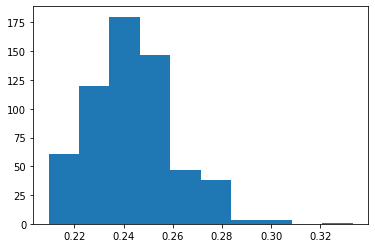

In [147]:
# Analizando los sensores constantes no encontramos valores tan elevados, aunque sí unos más alejados
# Se trata de los primeros instantes, aunque también son consecutivos
t_in = df_cons
df_train, df_test, X_train, X_test = train_test(t_in)
model_configs = {'n_ensemble':5, 'n_estimators':16, 'device':'cpu'}
df_test_score = score_anomalia(X_train, X_test, df_test, 'score', model_configs)

In [148]:
df_test_score[df_test_score['score']>0.30]

,day_time_index,Vacio_01,Vacio_05,Vacio_07,Vacio_11,Vacio_13,Vacio_19,Vacio_23,Vacio_25,Vacio_28,...,Vacio_52,Vacio_54,Vacio_56,Vacio_57,Vacio_58,Vacio_59,Vacio_60,Vacio_62,Vacio_63,score
ciclo,,,,,,,,,,,,,,,,,,,,,
2024_0105,3,-576.84,-568.69,-585.10,-591.00,-572.27,-588.18,-591.69,-578.54,-595.98,...,-587.70,-582.43,-586.82,-578.27,-578.06,-590.44,-588.36,-577.15,-578.50,0.300862
2024_0105,4,-560.78,-552.63,-560.06,-565.88,-556.46,-577.00,-566.15,-562.18,-570.96,...,-562.51,-565.87,-561.30,-561.91,-561.46,-564.69,-562.79,-560.55,-552.96,0.333261
2024_0105,5,-558.73,-550.50,-555.47,-561.29,-554.45,-567.32,-561.85,-560.11,-566.33,...,-558.34,-563.91,-556.88,-559.95,-559.54,-560.35,-558.49,-558.59,-548.58,0.306177
2024_0105,6,-558.90,-550.63,-555.55,-561.25,-554.66,-558.84,-561.89,-560.28,-566.45,...,-558.26,-564.07,-556.96,-560.15,-559.79,-560.43,-558.36,-558.71,-548.54,0.302148


## Ejecucion variables unicas

Entrenamos un algoritmo DIF para cada columna y obtenemos su score único

In [37]:
df_test_score = pd.DataFrame(columns=['day_time_index'])
t_in = df

for i in range(1, len(t_in.columns)): # len(df.columns)
    df_sens = separacion_sensor(t_in, i)
    df_train, df_test, X_train, X_test = train_test(df_sens)
    model_configs = {'n_ensemble':2, 'n_estimators':6, 'device':'cpu'}
    df_aux_score = score_anomalia(X_train, X_test, df_test, 'score_' + t_in.columns[i], model_configs)
    
    df_test_score = df_test_score.merge(df_aux_score, on = 'day_time_index', how = 'outer')
    print(df_test_score.shape)

['day_time_index', 'Vacio_01']
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 2}
0.30791878422364904
(600, 3)
['day_time_index', 'Vacio_03']
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 2}
0.3055920486167174
(600, 5)
['day_time_index', 'Vacio_05']
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 2}
0.33220611127296196
(600, 7)
['day_time_index', 'Vacio_07']
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 2}
0.3156355933642228
(600, 9)
['day_time_index', 'Vacio_11']
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size':

0.3281274170122795
(600, 81)


In [17]:
df_test_score

,day_time_index,Vacio_01,score_Vacio_01,Vacio_03,score_Vacio_03,Vacio_05,score_Vacio_05,Vacio_07,score_Vacio_07,Vacio_11,...,Vacio_60,score_Vacio_60,Vacio_61,score_Vacio_61,Vacio_62,score_Vacio_62,Vacio_63,score_Vacio_63,Vacio_64,score_Vacio_64
0,1,-592.70,0.230204,-588.25,0.225032,-584.46,0.211608,-589.32,0.212584,-595.34,...,-592.12,0.230407,-591.94,0.208989,-592.55,0.248846,-582.39,0.205867,-582.00,0.217255
1,2,-592.49,0.227719,-588.92,0.212533,-584.37,0.209077,-592.41,0.212185,-598.47,...,-595.33,0.227981,-592.23,0.207216,-592.34,0.242277,-585.56,0.205371,-582.00,0.198632
2,3,-576.84,0.226782,-588.67,0.212102,-568.69,0.209854,-585.10,0.209909,-591.00,...,-588.36,0.226690,-591.69,0.206297,-577.15,0.241229,-578.50,0.198298,-581.08,0.198118
3,4,-560.78,0.218204,-583.11,0.216619,-552.63,0.199134,-560.06,0.189535,-565.88,...,-562.79,0.218557,-586.60,0.206072,-560.55,0.227852,-552.96,0.198176,-576.87,0.197441
4,5,-558.73,0.216755,-574.93,0.204366,-550.50,0.197857,-555.47,0.188118,-561.29,...,-558.49,0.191788,-579.96,0.186974,-558.59,0.218130,-548.58,0.187792,-571.99,0.196604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,-564.45,0.247415,-260.59,0.260377,-556.34,0.217997,-564.44,0.334434,-570.05,...,-567.34,0.238472,-254.31,0.192628,-564.10,0.236826,-557.30,0.257200,-237.93,0.203457
596,597,-564.20,0.238186,-260.55,0.279508,-556.09,0.218934,-564.23,0.341415,-569.68,...,-567.08,0.242151,-254.31,0.188602,-563.76,0.254227,-557.05,0.259181,-237.85,0.202597
597,598,-564.78,0.262204,-260.51,0.296157,-556.76,0.233126,-563.65,0.332131,-569.14,...,-566.58,0.261942,-254.39,0.186802,-564.47,0.270300,-556.47,0.283348,-237.85,0.200025
598,599,-564.87,0.266440,-260.59,0.285558,-556.72,0.235077,-562.69,0.354221,-568.26,...,-565.67,0.287075,-254.47,0.184232,-564.51,0.274061,-555.63,0.281696,-237.93,0.198165


In [14]:
df_test_score.to_csv('./score_individ_train93_test79.csv', index = False)

In [18]:
df_test_score.to_csv('./score_individ_train93_test105.csv', index = False)

In [21]:
df_test_score.to_csv('./score_individ_train79_105_test93.csv', index = False)

(array([ 35.,  43., 163., 173., 114.,  29.,  30.,  11.,   1.,   1.]),
 array([0.11471137, 0.13946404, 0.16421672, 0.18896939, 0.21372207,
        0.23847474, 0.26322742, 0.28798009, 0.31273277, 0.33748544,
        0.36223812]),
 <BarContainer object of 10 artists>)

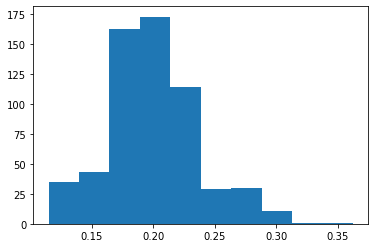

In [45]:
plt.hist(df_test_score['score_Vacio_60'])

In [46]:
df_test_score[df_test_score['score_Vacio_60']>0.30]

,day_time_index,Vacio_01,score_Vacio_01,Vacio_03,score_Vacio_03,Vacio_05,score_Vacio_05,Vacio_07,score_Vacio_07,Vacio_11,...,Vacio_60,score_Vacio_60,Vacio_61,score_Vacio_61,Vacio_62,score_Vacio_62,Vacio_63,score_Vacio_63,Vacio_64,score_Vacio_64
297,298,-562.74,0.277029,-292.60,0.239106,-555.05,0.250479,-560.27,0.284052,-565.96,...,-563.41,0.311871,-262.94,0.224395,-562.68,0.272638,-553.34,0.276343,-212.77,0.234159
307,308,-561.82,0.267696,-288.32,0.287876,-554.01,0.227443,-561.19,0.281836,-566.96,...,-564.37,0.307328,-256.43,0.231600,-561.51,0.252815,-554.38,0.277072,-205.68,0.246465
597,598,-561.78,0.307919,-272.55,0.282986,-554.01,0.304953,-560.31,0.292055,-566.09,...,-563.37,0.305091,-244.29,0.230109,-561.55,0.300823,-553.59,0.281396,-199.75,0.263149
598,599,-562.07,0.289271,-272.63,0.273586,-554.18,0.306791,-560.39,0.296944,-566.13,...,-563.54,0.321858,-244.21,0.230234,-561.84,0.298995,-553.80,0.288751,-199.83,0.263184
599,600,-561.44,0.307119,-272.59,0.268633,-553.67,0.332206,-560.56,0.296955,-566.21,...,-563.58,0.362238,-244.16,0.230435,-561.34,0.313634,-553.71,0.294599,-199.83,0.263204


In [35]:
df_test_score['score_Vacio_07'].tail(10)

590    0.231877
591    0.232230
592    0.254549
593    0.270851
594    0.275169
595    0.334434
596    0.341415
597    0.332131
598    0.354221
599    0.360790
Name: score_Vacio_07, dtype: float64